# MS Calculations

Notebook to crunch numbers for the MS.

by Cascade Tuholske 2020.02.23

In [28]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [29]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [30]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/All_data_HI406_figdata.csv'
#FN_IN = '/home/cascade/projects/UrbanHeat/data/processed/oldworkflow/All_data_Raw406_es_final_pdayadd.csv'

# STATS IN
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# GHS-UCDB IN
GHS_FN = 'raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp'
GHS = gpd.read_file(DATA_IN+GHS_FN)
print('Len of GHS-UCDB (all cities) is', len(GHS))

# Check it
HI_STATS.head()

Len of GHS-UCDB (all cities) is 13135


,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,1.041289e+05,1.041289e+05,0.0
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,1.940889e+05,1.940889e+05,0.0
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,8.054078e+04,8.054078e+04,0.0
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,5.338887e+05,5.338887e+05,0.0
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,2.692151e+06,2.692151e+06,0.0


In [31]:
#### Drop 40 cities where P1983 == 40 -- see comments in Fig 2 & 3 code CPT 2020.03.03
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city IDS
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

392972
391612
391408


In [32]:
## Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/All_data_HI406_meta.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS= HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')
HI_STATS.head()


,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop,region,intermediate-region,sub-region,CTR_MN_NM,GCPNT_LAT,GCPNT_LON
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,1.041289e+05,1.041289e+05,0.0,Americas,Northern America,Northern America,United States,37.688409,-121.753980
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,1.940889e+05,1.940889e+05,0.0,Americas,Northern America,Northern America,United States,37.985433,-121.797516
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,8.054078e+04,8.054078e+04,0.0,Americas,Northern America,Northern America,United States,38.264013,-122.030253
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,5.338887e+05,5.338887e+05,0.0,Americas,Northern America,Northern America,United States,37.730079,-121.431413
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,2.692151e+06,2.692151e+06,0.0,Americas,Northern America,Northern America,United States,35.363810,-119.047535


# Global Trends

In [40]:
#### Total Change in people Days
data = HI_STATS.groupby('year')['people_days'].sum()
year = str(data.index[33])
value = str(data.values[33]/10**9)
print('person days in 2016 was '+value+' billion')

year = str(data.index[0])
value = str(data.values[0]/10**9)
print('person days in 1983 was '+value+' billion')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print('pct increase in people days 83 - 16 is ', out)

#### Rate of change
data = HI_STATS
coef, r2, p = lm_func(data, 'people_days')
print('annual increase in people days ', 'was', coef/10**6, ' p=', p)
coef1, r21, p1 = lm_func(data, 'people_days_heat')
print('annual increase in people days heat ', 'was', coef1/10**6, ' p=', p)
coef2, r22, p2 = lm_func(data, 'people_days_pop')
print('annual increase in people days pop ', 'was', coef2/10**6, ' p=', p)
print('attrib heat ', 'was', coef1 / coef *100, ' p=', p, '\n')

person days in 2016 was 301.6721232336765 billion
person days in 1983 was 129.1721854485311 billion
pct increase in people days 83 - 16 is  133.5426331807928
annual increase in people days  was 5138.121501  p= 0.0
annual increase in people days heat  was 1179.223093  p= 0.0
annual increase in people days pop Western Europe was 3958.898407  p= 0.0
attrib heat  was 22.950471155080614  p= 0.0 



In [34]:
#### Pct Pday Annual Increase from Heat
coef_pdays, r2_pdays, p_pdays = lm_func(HI_STATS, 'people_days') # regress pdays
coef_heat, r2_heat, p_heat = lm_func(HI_STATS, 'people_days_heat') # regreas heat

print('warming is what pct of total?', coef_heat/coef_pdays *100)

warming is what pct of total? 22.950471155080614


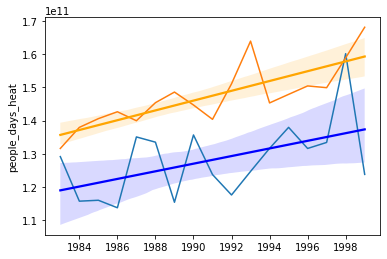

In [35]:
#### Share of exposure due to heat by decade

## 1983 - 1999
data1 = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef1pop , r21pop, p1pop  = lm_func(data1 , 'people_days_pop')
coef1heat , r21heat, p1heat = lm_func(data1 , 'people_days_heat')

years = list(np.unique(data1['year']))
plt.plot(years, data1.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data1.groupby('year')['people_days_heat'].sum(), 
            color = 'blue', scatter = False, truncate = True)

## 2000 - 2016
data2 = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2 , 'people_days_heat')
coef2pop , r22pop, p1pop  = lm_func(data2 , 'people_days_pop')

years = list(np.unique(data1['year']))
plt.plot(years, data2.groupby('year')['people_days_heat'].sum())
sns.regplot(years, data2.groupby('year')['people_days_heat'].sum(), 
            color = 'orange', scatter = False, truncate = True)

In [36]:
## 2000 - 2016
data2pop = HI_STATS[(HI_STATS['year'] >= 1983) & (HI_STATS['year'] < 2000)]
coef2pop , r22pop, p1pop  = lm_func(data2pop , 'people_days_pop')

data2heat = HI_STATS[(HI_STATS['year'] >= 2000) & (HI_STATS['year'] <= 2016)]
coef2heat , r22heat, p2heat = lm_func(data2heat , 'people_days_heat')


In [37]:

## Estimates
print('From 83 - 99, contribution from heat was', coef1heat/(coef1pop+coef1heat))
print('From 00 - 16, contribution from heat was', coef2heat/(coef2pop+coef2heat))
print('From 83 - 00, heat was', coef1heat/10**9, round(p1heat, 3))
print('From 00 - 16, heat was', coef2heat/10**9)
print('From 83 - 00, pop was', coef1pop/10**9)
print('From 00 - 16, pop was', coef2pop/10**9)

From 83 - 99, contribution from heat was 0.24437823785325977
From 00 - 16, contribution from heat was 0.2937183916708305
From 83 - 00, heat was 1.146691375 0.051
From 00 - 16, heat was 1.474489616
From 83 - 00, pop was 3.545589677
From 00 - 16, pop was 3.545589677


# Regional Trends

In [38]:
#### Annual Rates

for label in np.unique(HI_STATS['sub-region']):
    geog = 'sub-region'
    label = label
    data = HI_STATS[HI_STATS[geog] == label]
    
    #### Rate of change
    coef, r2, p = lm_func(data, 'people_days')
    print('annual increase in people days '+label, 'was', coef/10**6, ' p=', p)
    coef1, r21, p1 = lm_func(data, 'people_days_heat')
    print('annual increase in people days heat '+label, 'was', coef1/10**6, ' p=', p)
    coef2, r22, p2 = lm_func(data, 'people_days_pop')
    print('annual increase in people days pop '+label, 'was', coef2/10**6, ' p=', p)
    print('attrib heat '+label, 'was', coef1 / coef *100, ' p=', p, '\n')
  

annual increase in people days Australia and New Zealand was 1.958395  p= 0.0
annual increase in people days heat Australia and New Zealand was 0.85233  p= 0.0
annual increase in people days pop Australia and New Zealand was 1.106064  p= 0.0
attrib heat Australia and New Zealand was 43.52186356684938  p= 0.0 

annual increase in people days Central Asia was 1.523626  p= 0.0
annual increase in people days heat Central Asia was 0.643426  p= 0.0
annual increase in people days pop Central Asia was 0.880199  p= 0.0
attrib heat Central Asia was 42.229917315666704  p= 0.0 

annual increase in people days Eastern Asia was 425.761182  p= 0.0
annual increase in people days heat Eastern Asia was 111.689309  p= 0.0
annual increase in people days pop Eastern Asia was 314.071873  p= 0.0
attrib heat Eastern Asia was 26.23285393829069  p= 0.0 

annual increase in people days Eastern Europe was 7.841576  p= 0.009
annual increase in people days heat Eastern Europe was 7.604052  p= 0.009
annual increase 

In [41]:
#### S Asia as pct of total 

print('pct of total pdays from S Asia is ', 1931.627575 /5138.121501 * 100)

pct of total pdays from S Asia is  37.59404238736004


In [46]:
#### Which region contributed the most people-days from warming and Pop?

global_pdays = 5138.121501 * 10**6
global_heat = 1179.223093 * 10**6# see above
global_pop = 3958.898407 * 10**6

for label in np.unique(HI_STATS['sub-region']):
    geog = 'sub-region'
    label = label
    data = HI_STATS[HI_STATS[geog] == label]
    
    #### Rate of change
    coef, r2, p = lm_func(data, 'people_days')
    print('pct annual increase in people days '+label, 'was', coef/global_pdays * 100 , ' p=', p)
    coef1, r21, p1 = lm_func(data, 'people_days_heat')
    print('pct annual increase in people days heat '+label, 'was', coef1/global_heat * 100 , ' p=', p)
    coef2, r22, p2 = lm_func(data, 'people_days_pop')
    print('pct annual increase in people days pop '+label, 'was', coef2/global_pop * 100 , ' p=', p, '\n')

  

pct annual increase in people days Australia and New Zealand was 0.038114999803310415  p= 0.0
pct annual increase in people days heat Australia and New Zealand was 0.07227894408272073  p= 0.0
pct annual increase in people days pop Australia and New Zealand was 0.027938681074621476  p= 0.0 

pct annual increase in people days Central Asia was 0.029653366501813286  p= 0.0
pct annual increase in people days heat Central Asia was 0.05456355152976978  p= 0.0
pct annual increase in people days pop Central Asia was 0.022233432372087643  p= 0.0 

pct annual increase in people days Eastern Asia was 8.286319852832145  p= 0.0
pct annual increase in people days heat Eastern Asia was 9.471431628417067  p= 0.0
pct annual increase in people days pop Eastern Asia was 7.933314793950458  p= 0.0 

pct annual increase in people days Eastern Europe was 0.15261562028990253  p= 0.009
pct annual increase in people days heat Eastern Europe was 0.6448357435618842  p= 0.009
pct annual increase in people days pop

In [ ]:
data.head()

In [ ]:
#### Total Change in people Days

for label in np.unique(HI_STATS['sub-region']):
    geog = 'sub-region'
    label = label
    data = HI_STATS[HI_STATS[geog] == label]
    
    #### Change 1983 - 2016 
    data = data.groupby('year')['people_days'].sum()
    year1 = str(data.index[33])
    value1 = data.values[33]/10**9
    print(label,' person days in 2016 was ',value1,' billion')

    year2 = str(data.index[0])
    value2 = data.values[0]/10**9
    print(label,' person days in 1983 was ', value2, ' billion')
    
    #### Total Change 
    print('Total change was', (value1 - value2) * 10**3, ' person-days')

    #### Pct Change in Poeple Days 1983 - 2016
    pdays16 = data.iloc[len(data) -1]
    pdays83 = data.iloc[0]
    out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
    print(label,' pct increase in people days 83 - 16 is ', out, '\n')
    

In [ ]:
#### Europe
geog = 'region'
label = 'Europe'
data = HI_STATS[HI_STATS[geog] == label]
data = data.groupby('year')['people_days'].sum()
year1 = str(data.index[33])
value1 = data.values[33]/10**9
print(label,' person days in 2016 was ',value1,' billion')

year2 = str(data.index[0])
value2 = data.values[0]/10**9
print(label,' person days in 1983 was ', value2, ' billion')

#### Total Change 
print('Total change was', (value1 - value2) * 10**3, ' person-days')

#### Pct Change in Poeple Days 1983 - 2016
pdays16 = data.iloc[len(data) -1]
pdays83 = data.iloc[0]
out = (data.iloc[len(data) -1] - data.iloc[0]) / data.iloc[0] * 100
print(label,' pct increase in people days 83 - 16 is ', out, '\n')

# City-level

In [47]:
all_coefs = pd.read_csv(DATA_IN+'/processed/All_data_HI406_figdata_map_totDays_p05.csv')

In [48]:
all_coefs.columns

Index(['Unnamed: 0', 'ID_HDC_G0', 'coef_pdays', 'p_value_pdays',
       'ci_left_pdays', 'ci_right_pdays', 'coef_heat', 'p_value_heat',
       'ci_left_heat', 'ci_right_heat', 'coef_pop', 'p_value_pop',
       'ci_left_pop', 'ci_right_pop', 'coef_totDays', 'p_value_totDays',
       'ci_left_totDays', 'ci_right_totDays', 'coef_attrib',
       'coef_attrib_left', 'coef_attrib_right', 'coef_attrib_norm',
       'coef_attrib_norm_left', 'coef_attrib_norm_right', 'region',
       'intermediate-region', 'sub-region', 'CTR_MN_NM', 'GCPNT_LAT',
       'GCPNT_LON', 'P1983', 'P2016'],
      dtype='object')

In [49]:
### Rates of exposure due to pop or heat (switch cols)

col = 'coef_pop' # 'coef_heat'
for label in np.unique(all_coefs['sub-region']):
    geog = 'sub-region'
    label = label
    data = all_coefs[all_coefs[geog] == label]
    results = data[col].quantile([.25, .5, .75])
    
    print(label, ' ', results)
    print('median', data[col].median(), '\n')

Australia and New Zealand   0.25     8800.347274
0.50    19553.819165
0.75    55303.479501
Name: coef_pop, dtype: float64
median 19553.819164701803 

Central Asia   0.25     1112.541037
0.50     2918.923145
0.75    11332.777559
Name: coef_pop, dtype: float64
median 2918.923144751925 

Eastern Asia   0.25      6683.165022
0.50     29018.687993
0.75    108326.820845
Name: coef_pop, dtype: float64
median 29018.687992527684 

Eastern Europe   0.25      789.452527
0.50     2184.046446
0.75    11220.120106
Name: coef_pop, dtype: float64
median 2184.0464461039637 

Latin America and the Caribbean   0.25     38156.119850
0.50    121236.490424
0.75    335545.112120
Name: coef_pop, dtype: float64
median 121236.49042391288 

Melanesia   0.25     32318.880274
0.50     71296.695864
0.75    133255.322773
Name: coef_pop, dtype: float64
median 71296.69586353978 

Northern Africa   0.25     31647.297693
0.50     63903.423008
0.75    125285.852893
Name: coef_pop, dtype: float64
median 63903.42300764535 

In [50]:
#### Top Fifty Cities Worldwide Pdays
data = all_coefs[['ID_HDC_G0', 'CTR_MN_NM', 'coef_pdays']].sort_values('coef_pdays', ascending = False)
rank = list(range(1,len(data)+1))
data['rank'] = rank
data.head(50)

,ID_HDC_G0,CTR_MN_NM,coef_pdays,rank
5684,9872,Bangladesh,1.108102e+08,1
6125,10715,Thailand,9.611894e+07,2
6474,12080,China,8.261109e+07,3
6709,12829,Philippines,7.800308e+07,4
6392,11800,Vietnam,7.737457e+07,5
3172,6955,India,7.647798e+07,6
6409,11862,Indonesia,7.006272e+07,7
990,2125,Nigeria,5.035992e+07,8
5506,9691,India,5.028675e+07,9
2519,6169,Pakistan,5.014740e+07,10


In [52]:
#### Delhi
city = 6955
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Delhi increased', coef / 10**6)

Delhi increased 76.477979


In [ ]:
#### Lagos
city = 2125
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Lagos increased', coef)

In [ ]:
#### Miami 
city = 556
data = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
coef, r2, p = lm_func(data, 'people_days')
print('Miami increased', coef)

In [ ]:
#### Top Fifty Cities Worldwide Heating
data = all_coefs[['ID_HDC_G0', 'CTR_MN_NM', 'coef_totDays']].sort_values('coef_totDays', ascending = False)
rank = list(range(1,len(data)+1))
data['rank'] = rank
data.head(50)

In [62]:
#### How many cities out all cities experienced warmingp
print('globally : ', len(HI_STATS.drop_duplicates('ID_HDC_G0')) /len(GHS))

## India



globally :  0.8764370003806623


11512